In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change this path to match your actual file location
dataset_path = '/content/drive/MyDrive/LanguageDetection.csv'


In [ ]:
!pip install transformers==4.39.3
!pip install datasets==2.18.0
!pip install scikit-learn==1.3.0
!pip install torch==2.2.2
!pip install tensorflow==2.15.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.39.3 which is incompatible.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requir

In [ ]:
#STEP 3: Load Dataset and Preprocess
import pandas as pd

# Load dataset
df = pd.read_csv(dataset_path)

# Preview
print(df.head())

# Map languages to numeric labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Language'])

# For model use
texts = df['Text'].tolist()
labels = df['label'].tolist()


                                                Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English


In [ ]:
#STEP 4: Tokenize with BERT Tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
#STEP 5: Create BERT Model for Classification
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import BertForSequenceClassification

# Prepare tensors
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']
labels_tensor = torch.tensor(labels)

# Dataset & Dataloader
dataset = TensorDataset(input_ids, attention_masks, labels_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_data, batch_size=16)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(le.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
#STEP 6: Train BERT Model
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_dataloader, leave=True)
    for batch in loop:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 2: 100%|██████████| 517/517 [03:12<00:00,  2.68it/s, loss=0.00857]


In [ ]:
#STEP 7: Evaluate BERT Model
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

      Arabic       1.00      0.99      1.00       103
      Danish       0.99      0.96      0.97        90
       Dutch       0.92      1.00      0.96       110
     English       1.00      0.99      1.00       285
      French       1.00      0.98      0.99       184
      German       0.98      0.98      0.98       101
       Greek       1.00      1.00      1.00        80
       Hindi       1.00      1.00      1.00        12
     Italian       0.99      0.99      0.99       134
     Kannada       1.00      1.00      1.00        79
   Malayalam       1.00      1.00      1.00        91
  Portugeese       0.98      0.97      0.98       148
     Russian       1.00      1.00      1.00       146
     Spanish       0.97      0.98      0.98       184
    Sweedish       0.99      0.99      0.99       138
       Tamil       1.00      0.99      0.99        88
     Turkish       0.99      0.99      0.99        95

    accuracy              

In [ ]:
import torch

# Assuming `model` is your BERT model
torch.save(model.state_dict(), 'bert_language_detection.pth')


In [ ]:
from transformers import BertTokenizer

tokenizer.save_pretrained('./bert_tokenizer')


('./bert_tokenizer/tokenizer_config.json',
 './bert_tokenizer/special_tokens_map.json',
 './bert_tokenizer/vocab.txt',
 './bert_tokenizer/added_tokens.json')

In [ ]:
from google.colab import files
files.download('bert_language_detection.pth')  # or .h5 or .zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

def detect_language(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move model and inputs to GPU if available
    if torch.cuda.is_available():
        model.cuda()
        inputs = {k: v.cuda() for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Convert numeric label to actual language
    predicted_language = le.inverse_transform([predicted_class])[0]
    return predicted_language


In [ ]:
print(detect_language("Hello, how are you?"))         # Expect: English (or whatever it is in your data)
print(detect_language("Bonjour tout le monde"))       # Expect: French
print(detect_language("नमस्ते, आप कैसे हैं?"))        # Expect: Hindi
print(detect_language("Hola, ¿cómo estás?"))          # Expect: Spanish


English
French
Hindi
Spanish


In [ ]:
#Bulk Prediction on the Whole Dataset
df['predicted_language'] = df['Text'].apply(detect_language)
print(df[['Text', 'Language', 'predicted_language']].head(10))


                                                Text Language  \
0   Nature, in the broadest sense, is the natural...  English   
1  "Nature" can refer to the phenomena of the phy...  English   
2  The study of nature is a large, if not the onl...  English   
3  Although humans are part of nature, human acti...  English   
4  [1] The word nature is borrowed from the Old F...  English   
5  [2] In ancient philosophy, natura is mostly us...  English   
6  [3][4] \nThe concept of nature as a whole, the...  English   
7  During the advent of modern scientific method ...  English   
8  [5][6] With the Industrial revolution, nature ...  English   
9  However, a vitalist vision of nature, closer t...  English   

  predicted_language  
0            English  
1            English  
2            English  
3            English  
4            English  
5              Greek  
6              Greek  
7            English  
8            English  
9            English  


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [ ]:
from transformers import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Accuracy tracking
        logits = outputs.logits.detach().cpu()
        preds = torch.argmax(logits, dim=1).numpy()
        labels = b_labels.cpu().numpy()
        correct += (preds == labels).sum()
        total += len(labels)

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # === Validation ===
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_acc = accuracy_score(val_labels, val_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")


Epoch 0: 100%|██████████| 517/517 [03:14<00:00,  2.66it/s, loss=0.00128]



Epoch 1: Train Acc=0.9964, Val Acc=0.9923, Train Loss=0.0193, Val Loss=0.0454


Epoch 1: 100%|██████████| 517/517 [03:13<00:00,  2.67it/s, loss=0.00101]



Epoch 2: Train Acc=0.9970, Val Acc=0.9908, Train Loss=0.0136, Val Loss=0.0560


Epoch 2: 100%|██████████| 517/517 [03:13<00:00,  2.67it/s, loss=0.000986]



Epoch 3: Train Acc=0.9960, Val Acc=0.9913, Train Loss=0.0158, Val Loss=0.0431


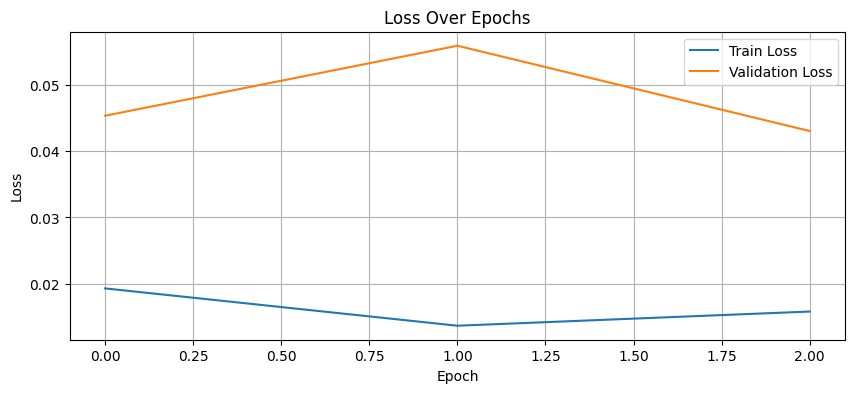

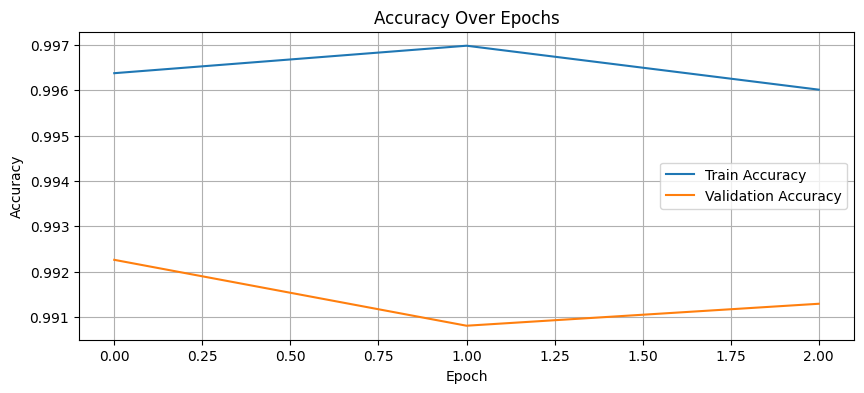

In [ ]:
#1. Plot Accuracy & Loss Curves
import matplotlib.pyplot as plt

# Loss Plot
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


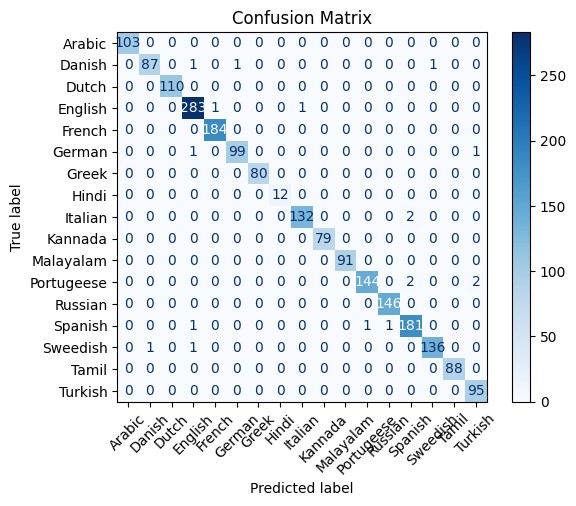

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#classification Report
from sklearn.metrics import classification_report

print(classification_report(val_labels, val_preds, target_names=le.classes_))


              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       103
      Danish       0.99      0.97      0.98        90
       Dutch       1.00      1.00      1.00       110
     English       0.99      0.99      0.99       285
      French       0.99      1.00      1.00       184
      German       0.99      0.98      0.99       101
       Greek       1.00      1.00      1.00        80
       Hindi       1.00      1.00      1.00        12
     Italian       0.99      0.99      0.99       134
     Kannada       1.00      1.00      1.00        79
   Malayalam       1.00      1.00      1.00        91
  Portugeese       0.99      0.97      0.98       148
     Russian       0.99      1.00      1.00       146
     Spanish       0.98      0.98      0.98       184
    Sweedish       0.99      0.99      0.99       138
       Tamil       1.00      1.00      1.00        88
     Turkish       0.97      1.00      0.98        95

    accuracy              